In [1]:
import os
import math
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
cur_dir = os.getcwd()
input_data_folder = os.path.join(cur_dir, 'input_data')

In [3]:
# Create the input_data folder if it doesn't exist
if not os.path.exists(input_data_folder):
    os.makedirs(input_data_folder)

In [4]:
# Download the dataset
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"
dataset_zip_path = os.path.join(input_data_folder, 'dataset_diabetes.zip')

In [ ]:
# Download the file
response = requests.get(dataset_url)
with open(dataset_zip_path, 'wb') as f:
    f.write(response.content)

In [ ]:
# Unzip the dataset
import zipfile
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(input_data_folder)

In [5]:
# Load the dataset into a DataFrame
data_file_path = os.path.join(input_data_folder, 'dataset_diabetes/diabetic_data.csv')
df= pd.read_csv(data_file_path)

## Common Functions

In [6]:
#Checking the unique values of the columns
def get_unique_values(data):
  for col in data.columns:
    print(f"Unique values of {col}: {data[col].unique()}")

In [7]:
def get_rows_columns_dtypes(data):
    # Print the shape
    # Overview of dataframe
    rows = data.shape[0]
    cols = data.shape[1]
    print('#samples  (rows)    =  {}'.format(rows))
    print('#features (columns) =  {}'.format(cols))
    
    # Print the data types dtypes
    print("\nData types:\n", data.dtypes)

In [8]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
def check_missing_values(data):
  for col in data.columns:
    num_missing = data[col][data[col] == '?'].count()
    percent_missing = (data[col] == '?').mean() * 100
    print(f'{col},\t {num_missing},\t {percent_missing:.2f}%')

In [9]:
# get list of only numeric features
def get_numeric_features(data, forecast_column=None):
    if forecast_column:
        return(list(set(list(df._get_numeric_data().columns))- {forecast_column}))
    return(list(set(list(df._get_numeric_data().columns))))

In [10]:
# get list of only categorical features
def get_categorical_features(data, col_exclude=None):
    cat_col = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    if col_exclude:
        cat_col = [col for col in cat_col if col != col_exclude]
    return(cat_col)

In [11]:
# standardize function
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

## Data Cleaning

In [12]:
# First 10 rows of the dataset
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
weight,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12


In [13]:
# Shape and dtypes
get_rows_columns_dtypes(df)

#samples  (rows)    =  101766
#features (columns) =  50

Data types:
 encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide         

In [14]:
get_unique_values(df)

Unique values of encounter_id: [  2278392    149190     64410 ... 443854148 443857166 443867222]
Unique values of patient_nbr: [  8222157  55629189  86047875 ... 140199494 120975314 175429310]
Unique values of race: ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
Unique values of gender: ['Female' 'Male' 'Unknown/Invalid']
Unique values of age: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
Unique values of weight: ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
Unique values of admission_type_id: [6 1 2 3 4 5 8 7]
Unique values of discharge_disposition_id: [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
Unique values of admission_source_id: [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
Unique values of time_in_hospital: [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
Unique values of payer_code: ['?' 'MC' 'MD' 'HM' 'UN' 'BC' '

In [15]:
check_missing_values(df)

encounter_id,	 0,	 0.00%
patient_nbr,	 0,	 0.00%
race,	 2273,	 2.23%
gender,	 0,	 0.00%
age,	 0,	 0.00%
weight,	 98569,	 96.86%
admission_type_id,	 0,	 0.00%
discharge_disposition_id,	 0,	 0.00%
admission_source_id,	 0,	 0.00%
time_in_hospital,	 0,	 0.00%
payer_code,	 40256,	 39.56%
medical_specialty,	 49949,	 49.08%
num_lab_procedures,	 0,	 0.00%
num_procedures,	 0,	 0.00%
num_medications,	 0,	 0.00%
number_outpatient,	 0,	 0.00%
number_emergency,	 0,	 0.00%
number_inpatient,	 0,	 0.00%
diag_1,	 21,	 0.02%
diag_2,	 358,	 0.35%
diag_3,	 1423,	 1.40%
number_diagnoses,	 0,	 0.00%
max_glu_serum,	 0,	 0.00%
A1Cresult,	 0,	 0.00%
metformin,	 0,	 0.00%
repaglinide,	 0,	 0.00%
nateglinide,	 0,	 0.00%
chlorpropamide,	 0,	 0.00%
glimepiride,	 0,	 0.00%
acetohexamide,	 0,	 0.00%
glipizide,	 0,	 0.00%
glyburide,	 0,	 0.00%
tolbutamide,	 0,	 0.00%
pioglitazone,	 0,	 0.00%
rosiglitazone,	 0,	 0.00%
acarbose,	 0,	 0.00%
miglitol,	 0,	 0.00%
troglitazone,	 0,	 0.00%
tolazamide,	 0,	 0.00%
examide,	 0

In [16]:
# gender was coded differently so we use a custom count for this one            
print('Missing values in gender:', df['gender'][df['gender'] == 'Unknown/Invalid'].count())

Missing values in gender: 3


Variable weight contains approximate 98% of the missing values so there is no significance in filling those missing values so we decided to drop these variables. Variable Payer code and medical specialty contains approximate 40% or mpre missing values so we also dropped these variables. 

In [17]:
# Drop weight, payer_code, and medical_speciality features
df = df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

Variables race, diag_1, diag_2, diag_3 and gender contains very less missing values as compared to other attributes which we dropped so for these attributes we also decided to drop those where missing values contains.

In [18]:
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(df['diag_1'][df['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_2'][df['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_3'][df['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['race'][df['race'] == '?'].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

variables (drugs named citoglipton and examide and metformin-rosiglitazone), all records have the same value. So essentially these cannot provide any interpretive or discriminatory information for predicting readmission so we decided to drop these two variables

In [19]:
df = df.drop(['citoglipton', 'examide', 'metformin-rosiglitazone'], axis = 1)

In [20]:
# Check missing values
check_missing_values(df)

encounter_id,	 0,	 0.00%
patient_nbr,	 0,	 0.00%
race,	 0,	 0.00%
gender,	 0,	 0.00%
age,	 0,	 0.00%
admission_type_id,	 0,	 0.00%
discharge_disposition_id,	 0,	 0.00%
admission_source_id,	 0,	 0.00%
time_in_hospital,	 0,	 0.00%
num_lab_procedures,	 0,	 0.00%
num_procedures,	 0,	 0.00%
num_medications,	 0,	 0.00%
number_outpatient,	 0,	 0.00%
number_emergency,	 0,	 0.00%
number_inpatient,	 0,	 0.00%
diag_1,	 0,	 0.00%
diag_2,	 0,	 0.00%
diag_3,	 0,	 0.00%
number_diagnoses,	 0,	 0.00%
max_glu_serum,	 0,	 0.00%
A1Cresult,	 0,	 0.00%
metformin,	 0,	 0.00%
repaglinide,	 0,	 0.00%
nateglinide,	 0,	 0.00%
chlorpropamide,	 0,	 0.00%
glimepiride,	 0,	 0.00%
acetohexamide,	 0,	 0.00%
glipizide,	 0,	 0.00%
glyburide,	 0,	 0.00%
tolbutamide,	 0,	 0.00%
pioglitazone,	 0,	 0.00%
rosiglitazone,	 0,	 0.00%
acarbose,	 0,	 0.00%
miglitol,	 0,	 0.00%
troglitazone,	 0,	 0.00%
tolazamide,	 0,	 0.00%
insulin,	 0,	 0.00%
glyburide-metformin,	 0,	 0.00%
glipizide-metformin,	 0,	 0.00%
glimepiride-pioglitazon

In [21]:
# Check missing values in gender           
print('Missing values in gender:', df['gender'][df['gender'] == 'Unknown/Invalid'].count())

Missing values in gender: 0


In [22]:
# Check features that have NULL values
print(df.isnull().sum())

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol  

In [23]:
get_rows_columns_dtypes(df)

#samples  (rows)    =  96446
#features (columns) =  44

Data types:
 encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide        

Here we are trying to predict the readmission 'No', '>30', or '<30' depending on the different features and hence we dont need he enounter id and patient id. But before we remove lets reduce the size and keep only the first and last entry. This will also prevent kernel crash errors

In [24]:
# dropping multiple encounters while keeping either first or last encounter of these patients
# # Sort the dataframe by patient_nbr and encounter_id (or date column if available)
# df_sorted = df.sort_values(['patient_nbr', 'encounter_id'])  # Replace 'encounter_id' with appropriate column if needed

# # Get the first encounter for each patient
# df_first = df_sorted.groupby('patient_nbr').first().reset_index()

# # Get the last encounter for each patient
# df_last = df_sorted.groupby('patient_nbr').last().reset_index()

# # Combine first and last encounters
# df2 = pd.concat([df_first, df_last]).drop_duplicates().reset_index(drop=True)

# # Sort the result by patient_nbr to group first and last encounters together
# df2 = df2.sort_values('patient_nbr')

# print(df2.shape)
df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df.shape

(67580, 44)

In [25]:
get_rows_columns_dtypes(df)

#samples  (rows)    =  67580
#features (columns) =  44

Data types:
 encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide        

In [26]:
df = df.drop(['encounter_id', 'patient_nbr'], axis = 1)

In [27]:
df.isnull().sum()

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide

In [28]:
get_rows_columns_dtypes(df)

#samples  (rows)    =  67580
#features (columns) =  42

Data types:
 race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide            

## Feature Engineering

### Dealing with age:
There are different ways to deal with this. The dataset only gives us age as 10 year categories, so we don’t know the exact age of each patient. The previous study on this dataset used age categories as nominal variables, but we wanted to be able to see the effect of increasing age on readmission, even if in a crude way. To do that, we assume that age of the patient on average lies at the midpoint of the age category. For example, if the patient’s age category is 20–30 years, then we assume the age = 25 years. So we converted age categories to midpoints, resulting in a numeric variable:

In [29]:
# code age intervals [0-10) - [90-100) from 1-10
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
df['age'].value_counts()

8     17331
7     15228
6     11903
9     10931
5      6494
4      2519
10     1750
3      1004
2       357
1        63
Name: age, dtype: int64

Convert age as categorical variable to a continuous approximation by assuming mid-point of each age-category as the actual age value. 
This is done to avoid having to deal with age as a dummy variable in the models which makes interpretation very cumbersome. 
Also, since age category is not purely nominal but ordinal, we do not want to lose that information by treating it as a simple categorical variable

In [30]:
df['age'] = df['age'].astype('int64')
print(df.age.value_counts())
# convert age categories to mid-point values
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df['age'] = df.age.map(age_dict)
print(df.age.value_counts())

8     17331
7     15228
6     11903
9     10931
5      6494
4      2519
10     1750
3      1004
2       357
1        63
Name: age, dtype: int64
75    17331
65    15228
55    11903
85    10931
45     6494
35     2519
95     1750
25     1004
15      357
5        63
Name: age, dtype: int64


In [31]:
get_rows_columns_dtypes(df)

#samples  (rows)    =  67580
#features (columns) =  42

Data types:
 race                        object
gender                      object
age                          int64
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide            

### Service utilization
The data contains variables for number of inpatient (admissions), emergency room visits and outpatient visits for a given patient in the previous one year. These are (crude) measures of how much hospital/clinic services a person has used in the past year. We added these three to create a new variable called service utilization (see figure below). The idea was to see which version gives us better results. Granted, we did not apply any special weighting to the three ingredients of service utilization but we wanted to try something simple at this stage.

In [32]:
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

### Number of medication changes
The dataset contains 23 features for 23 drugs (or combos) which indicate for each of these, whether a change in that medication was made or not during the current hospital stay of patient. Medication change for diabetics upon admission has been shown by previous research to be associated with lower readmission rates. We decided to count how many changes were made in total for each patient, and declared that a new feature. The reasoning here was to both simplify the model and possibly discover a relationship with number of changes regardless of which drug was changed.

In [33]:
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in drugs:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['numchange'] = 0
for col in drugs:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]
    
df['numchange'].value_counts()

0    50902
1    15702
2      900
3       73
4        3
Name: numchange, dtype: int64

### Number of medication used:
Another possibly related factor could be the total number of medications used by the patient (which may indicate severity of their condition and/or the intensity of care). So we created another feature by counting the medications used during the encounter (keys variable in code below is continued from above):

In [34]:
df['nummed'] = 0

drug_val_map = {'No': 0,
                'Steady': 1,
                'Up': 1,
                'Down': 1
                }

for col in drugs:
    df['nummed'] = df['nummed'] + df[col].map(drug_val_map)
df['nummed'].value_counts()

1    29975
0    16267
2    14865
3     5444
4      976
5       49
6        4
Name: nummed, dtype: int64

In [35]:
get_rows_columns_dtypes(df)

#samples  (rows)    =  67580
#features (columns) =  45

Data types:
 race                        object
gender                      object
age                          int64
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide            

In [36]:
get_unique_values(df)

Unique values of race: ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
Unique values of gender: ['Female' 'Male']
Unique values of age: [15 25 35 45 55 65 75 85 95  5]
Unique values of admission_type_id: [1 2 3 6 4 5 8 7]
Unique values of discharge_disposition_id: [ 1  3  6  2  5  7 25 10 14  4 18  8 12 13 17 16 22 23  9 15 20 28 24 19
 27]
Unique values of admission_source_id: [ 7  2  4  1  5 20  6  3 17  8  9 14 10 22 11 25 13]
Unique values of time_in_hospital: [ 3  2  1  4  5 13 12  9  7 10 11  6  8 14]
Unique values of num_lab_procedures: [ 59  11  44  51  31  70  73  68  33  47  62  60  55  49  75  45  29  35
  42  19  64  25  53  52  87  27  37  41  28  36  48  10   2  65  67  40
  58  57  32  83  34  39  69  38  22  96  46  72  78  56  61  88  66  43
  50   1  18  82  54   9  63  24  71  77  81  76  90  93   3 103  13  80
  85  16  15  12  30  23  17  21  79  26  95  97  84  14  74 105  86  98
  20   5   6   8   7  89  91  94  92   4 101 102  99 100 114 111 107 108
 

In [37]:
# glimepiride-pioglitazone is all No so it does not provide any additional information, dropping it
df = df.drop(['glimepiride-pioglitazone'], axis = 1)

In [38]:
get_rows_columns_dtypes(df)

#samples  (rows)    =  67580
#features (columns) =  44

Data types:
 race                        object
gender                      object
age                          int64
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide            

## EDA

>30 represents 32.0% of the cases
<30 represents 9.07% of the cases


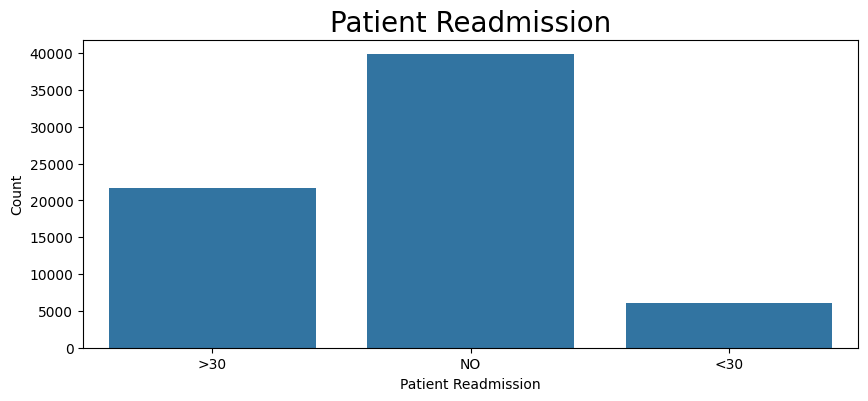

In [41]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))
sns.countplot(data=df, x="readmitted")
ax.set(xlabel='Patient Readmission', ylabel='Count')
ax.set_title('Patient Readmission', size=20)

cases_greater_30 = (df['readmitted']=='>30').sum()
print(f'>30 represents {round((cases_greater_30/len(df))*100,2)}% of the cases')

cases_less_30 = (df['readmitted']=='<30').sum()
print(f'<30 represents {round((cases_less_30/len(df))*100,2)}% of the cases')

In [42]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'service_utilization', 'numchange', 'nummed'],
      dtype='object')

In [43]:
x_quantitative = get_numeric_features(df)
x_quantitative

['nummed',
 'number_inpatient',
 'number_emergency',
 'num_procedures',
 'num_lab_procedures',
 'time_in_hospital',
 'service_utilization',
 'number_outpatient',
 'discharge_disposition_id',
 'number_diagnoses',
 'numchange',
 'admission_source_id',
 'age',
 'num_medications',
 'admission_type_id']

In [44]:
x_categorical = get_categorical_features(df, 'readmitted')
x_categorical

['race',
 'gender',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'metformin-pioglitazone',
 'change',
 'diabetesMed']

In [45]:
df.describe()

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,service_utilization,numchange,nummed
count,67580.00,67580.00,67580.00,67580.00,67580.00,67580.00,67580.00,67580.00,67580.00,67580.00,67580.00,67580.00,67580.00,67580.00,67580.00
mean,65.86,2.11,3.52,5.67,4.31,42.97,1.44,15.77,0.29,0.11,0.18,7.33,0.58,0.26,1.19
std,15.58,1.51,5.26,4.18,2.95,19.95,1.76,8.26,1.08,0.52,0.61,1.89,1.45,0.48,0.94
min,5.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00
25%,55.00,1.00,1.00,1.00,2.00,31.00,0.00,10.00,0.00,0.00,0.00,6.00,0.00,0.00,1.00
50%,65.00,1.00,1.00,7.00,4.00,44.00,1.00,14.00,0.00,0.00,0.00,8.00,0.00,0.00,1.00
75%,75.00,3.00,3.00,7.00,6.00,57.00,2.00,20.00,0.00,0.00,0.00,9.00,1.00,0.00,2.00
max,95.00,8.00,28.00,25.00,14.00,132.00,6.00,81.00,42.00,42.00,12.00,16.00,49.00,4.00,6.00


In [ ]:
def histplot_visual(data: pd.DataFrame, columns: list[str]) -> None:
  """Create a histogram plot using a subset of variables specified.

  Args:
    data: Input data-frame containing variables we wish to plot.
    columns: Listing of column-names we wish to plot (must be contained within data).
  """
  fig, ax = plt.subplots(3, 5, figsize=(15, 6))
  fig.suptitle('Histogram for each numeric variable in our data',y=1, size=20)
  ax=ax.flatten()
  for i,feature in enumerate(columns):
    # Setting option `kde=True` allows for a Kernel Density Estimate (i.e. PDF).
    sns.histplot(data=data[feature],ax=ax[i], kde=True)
  plt.tight_layout()

# Invoke our function defined above.
histplot_visual(data=df, columns=x_quantitative)

In [ ]:
for x in x_categorical:
    print(f'Unique values of {x}: {df[x].unique()}')
    print(df[x].value_counts(normalize=True))

In [ ]:
def count_plots(data: pd.DataFrame, columns: list[str]) -> None:
    """Create multiple plots using a subset of variables specified.

    Args:
        data: Input data-frame containing variables we wish to plot.
        columns: Listing of column-names we wish to plot (must be contained within data).
    """
    n_cols = 3  # Number of columns in the subplot grid
    n_rows = math.ceil(len(columns) / n_cols)  # Calculate number of rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    fig.suptitle('Countplot for each categorical variable in our data', y=1.02, size=20)
    
    axes = axes.flatten() if n_rows > 1 else [axes]  # Flatten only if multiple rows
    
    for i, feature in enumerate(columns):
        if i < len(axes):
            sns.countplot(data=data, x=feature, ax=axes[i])
            axes[i].set_title(feature)
            axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Invoke our function defined above.
count_plots(data=df, columns=x_categorical)

### Correlation

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True, cmap='coolwarm')
plt.show()

diag_1, diag_2, and diag_3 have just too many options. We need to collapse them into few options

In [ ]:
get_rows_columns_dtypes(df)

## Categorization of diagnoses:
The dataset contained up to three diagnoses for a given patient (primary, secondary and additional). However, each of these had 700–900 unique ICD codes and it is extremely difficult to include them in the model and interpret meaningfully. Therefore, we collapsed these diagnosis codes into 9 disease categories in an almost similar fashion to that done in the original publication using this dataset. These 9 categories include Circulatory, Respiratory, Digestive, Diabetes, Injury, Musculoskeletal, Genitourinary, Neoplasms, and Others. Although we did this for primary, secondary and additional diagnoses, we eventually decided to use only the primary diagnosis in our model. Doing this in python was slightly cumbersome because, well, we are mapping the disease codes to certain category names. Below code should demonstrate this easily.

In [ ]:
def categorize_diagnosis(code, level):
    code = float(code)
    
    if level == 1:
        categories = [
            (lambda x: (390 <= x < 460) or (np.floor(x) == 785), 1),
            (lambda x: (460 <= x < 520) or (np.floor(x) == 786), 2),
            (lambda x: (520 <= x < 580) or (np.floor(x) == 787), 3),
            (lambda x: np.floor(x) == 250, 4),
            (lambda x: 800 <= x < 1000, 5),
            (lambda x: 710 <= x < 740, 6),
            (lambda x: (580 <= x < 630) or (np.floor(x) == 788), 7),
            (lambda x: 140 <= x < 240, 8)
        ]
    else:  # level 2
        categories = [
            (lambda x: 390 <= x < 399, 1),
            (lambda x: 401 <= x < 415, 2),
            (lambda x: 415 <= x < 460, 3),
            (lambda x: np.floor(x) == 785, 4),
            (lambda x: 460 <= x < 489, 5),
            (lambda x: 490 <= x < 497, 6),
            (lambda x: 500 <= x < 520, 7),
            (lambda x: np.floor(x) == 786, 8),
            (lambda x: 520 <= x < 530, 9),
            (lambda x: 530 <= x < 544, 10),
            (lambda x: 550 <= x < 554, 11),
            (lambda x: 555 <= x < 580, 12),
            (lambda x: np.floor(x) == 787, 13),
            (lambda x: np.floor(x) == 250, 14),
            (lambda x: 800 <= x < 1000, 15),
            (lambda x: 710 <= x < 740, 16),
            (lambda x: 580 <= x < 630, 17),
            (lambda x: np.floor(x) == 788, 18),
            (lambda x: 140 <= x < 240, 19),
            (lambda x: 240 <= x < 280 and np.floor(x) != 250, 20),
            (lambda x: (680 <= x < 710) or (np.floor(x) == 782), 21),
            (lambda x: 290 <= x < 320, 22)
        ]
    
    for condition, category in categories:
        if condition(code):
            return category
    return 0

# Preprocessing
for i in range(1, 4):
    for level in [1, 2]:
        col = f'level{level}_diag{i}'
        df[col] = df[f'diag_{i}']
        df.loc[df[f'diag_{i}'].str.contains('V|E', na=False), col] = 0
        df[col] = df[col].replace('?', -1).astype(float)
        df[col] = df[col].apply(lambda x: categorize_diagnosis(x, level))

print(df[['level1_diag1', 'level2_diag1', 'level1_diag2', 'level2_diag2', 'level1_diag3', 'level2_diag3']].head())

In [ ]:
get_rows_columns_dtypes(df)

In [ ]:
get_unique_values(df)

In [ ]:
df = df.drop(['diag_1', 'diag_2', 'diag_3'], axis = 1)

In [ ]:
get_rows_columns_dtypes(df)

In [ ]:
plt.figure(figsize=(25,20))
sns.heatmap(df.corr(),annot=True, cmap='coolwarm')
plt.show()

In [ ]:
get_unique_values(df)

In [ ]:
x_quantitative = get_numeric_features(df)
x_quantitative

In [ ]:
x_categorical = get_categorical_features(df, col_exclude='readmitted')
x_categorical

## One-shot Encoding

In [ ]:
'''
One-hot encoding all the categorical features is a lot of features like 82 overall.
We run into memory issues when we try to fit the model

{
	"name": "",
	"message": "",
	"stack": "The Kernel crashed while executing code in the current cell or a previous cell. 
Please review the code in the cell(s) to identify a possible cause of the failure. 
Click <a href='https://aka.ms/vscodeJupyterKernelCrash'>here</a> for more info. 
View Jupyter <a href='command:jupyter.viewOutput'>log</a> for further details."
}
'''
'''
We will need to further reduce the number of features 
'''

In [ ]:
# drop individual diagnosis columns that have too granular disease information
# also drop level 2 categorization (which was not comparable with any reference)
# also drop level 1 secondary and tertiary diagnoses
df.drop(['level2_diag1', 'level1_diag2', 'level2_diag2', 'level1_diag3',
         'level2_diag3'], axis=1, inplace=True)

### label encoding max_glu_serum_map and a1c_result_map
Reduced both A1C test result and Glucose serum test result into categories of Normal, Abnormal and Not tested.

In [ ]:
'''
Unique values of max_glu_serum: ['None' '>300' 'Norm' '>200']
Unique values of A1Cresult: ['None' '>7' '>8' 'Norm']
'''
# Mapping for max_glu_serum
max_glu_serum_map = {
    'None': -99,
    'Norm': 0,
    '>200': 1,
    '>300': 2
}

# Mapping for A1Cresult
a1c_result_map = {
    'None': -99,
    'Norm': 0,
    '>7': 1,
    '>8': 2
}

# Apply mappings
df['max_glu_serum'] = df['max_glu_serum'].map(max_glu_serum_map)
df['A1Cresult'] = df['A1Cresult'].map(a1c_result_map)

# Verify the changes
print("Unique values in max_glu_serum after mapping:", df['max_glu_serum'].unique())
print("Unique values in A1Cresult after mapping:", df['A1Cresult'].unique())

## label encoding the prediction parameter readmitted
Whether you are in hospital for <30 days or >30 days, you are likely to be admitted. So we will label encode it to make it a binary classification/prediction

In [ ]:
readmitted = {
    'NO': 'False',
    '<30': 'True',
    '>30': 'True'
}

df['readmitted'] = df['readmitted'].map(readmitted)
# Verify the changes
print("Unique values in readmitted after mapping:", df['readmitted'].unique())

In [ ]:
'''
['No' 'Steady' 'Up' 'Down']
'''
keys = ['metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'metformin-pioglitazone']

key_map = { 'No': 0,
            'Steady': 1,
            'Up': 2,
            'Down': 3
}

for key in keys:
    df[key] = df[key].map(key_map)
    print(f"Unique values in {key} after mapping:", df[key].unique())

In [ ]:
x_quantitative = get_numeric_features(df)
x_quantitative

In [ ]:
x_categorical = get_categorical_features(df, col_exclude='readmitted')
x_categorical

In [ ]:
plt.figure(figsize=(30,25))
sns.heatmap(df.corr(),annot=True, cmap='coolwarm')
plt.show()

In [ ]:
df = pd.get_dummies(data=df, columns=x_categorical, drop_first=True)

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
print(get_rows_columns_dtypes(df))

## Model

In [ ]:
X = df.drop('readmitted', axis=1)
y = df['readmitted']
# Splitting our dataset between training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=100)

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
model_dict = clf.provide_models(X_train, X_test, y_train, y_test)

**Logistic Regression**
(Example provided)
Please ensure you use the right metric to evaluate classifer

In [ ]:
# Fit a logistic regression model to the training data
model1 = LogisticRegression(random_state = 42, max_iter = 1000)
model1.fit(X_train, y_train)
pred_test = model1.predict(X_test)
accuracy = accuracy_score(y_test, pred_test)
print('Accuracy:', round(accuracy,4))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

def accuracy_report(model, values_list):
    '''This function will assess model performance. Given a sklearn model it will Predict, and measure performance for both Test and Train Data'''
    #Train
    print('Train Data:\n-----------')
    pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, pred_train)
    print('Accuracy:', round(accuracy_train,4))
    print(classification_report(y_train, pred_train, target_names=values_list))
    roc_plot(model, X_train, y_train, values_list)
    
    print('Test Data:\n----------')
    pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, pred_test)
    print('Accuracy:', round(accuracy_test,4))
    print(classification_report(y_test, pred_test, target_names=values_list))
    roc_plot(model, X_test, y_test, values_list)

def roc_plot(model, X_data, y_data, values_list):
    # Binarize the output
    y_bin = label_binarize(y_data, classes=values_list)
    n_classes = len(values_list)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_score = model.predict_proba(X_data)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green']
    for i, color, lbl in zip(range(n_classes), colors, values_list):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(lbl, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for multi-class')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
accuracy_report(model1,['>30','NO','<30'])

**SVM**

In [ ]:
from sklearn.svm import SVC
model2 = SVC(kernel='linear', C=1, probability=True)
model2.fit(X_train, y_train)
accuracy_report(model2,['>30','NO','<30'])